# AirBnB data feature engineering

## Notebook set-up

Assume we are preparing this data for a linear regression model.

In [1]:
# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Internal imports
import gperdrizet_functions as funcs

label='price'

features=[
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

## 1. Data loading

In [2]:
raw_data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
raw_data_df.dropna(inplace=True)
datasets={'Raw': raw_data_df}
raw_data_df.head().transpose()

,0,1,3,4,5
id,2539,2595,3831,5022,5099
name,Clean & quiet apt home by the park,Skylit Midtown Castle,Cozy Entire Floor of Brownstone,Entire Apt: Spacious Studio/Loft by central park,Large Cozy 1 BR Apartment In Midtown East
host_id,2787,2845,4869,7192,7322
host_name,John,Jennifer,LisaRoxanne,Laura,Chris
neighbourhood_group,Brooklyn,Manhattan,Brooklyn,Manhattan,Manhattan
neighbourhood,Kensington,Midtown,Clinton Hill,East Harlem,Murray Hill
latitude,40.64749,40.75362,40.68514,40.79851,40.74767
longitude,-73.97237,-73.98377,-73.95976,-73.94399,-73.975
room_type,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
price,149,225,89,80,200


In [3]:
raw_data_df[features].describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,38821.000000,38821.000000,38821.000000,38821.000000,38821.000000
mean,5.869220,29.290255,1.373229,5.166611,114.886299
std,17.389026,48.182900,1.680328,26.302954,129.529950
min,1.000000,1.000000,0.010000,1.000000,0.000000
25%,1.000000,3.000000,0.190000,1.000000,0.000000
50%,2.000000,9.000000,0.720000,1.000000,55.000000
75%,4.000000,33.000000,2.020000,2.000000,229.000000
max,1250.000000,629.000000,58.500000,327.000000,365.000000


## 2. Box-Cox transformation

In [4]:
transformed_data_df=raw_data_df.copy()
transformed_data_df[features]=power_transform(transformed_data_df[features]+1, method='box-cox')
transformed_data_df[label]=power_transform(transformed_data_df[label].to_frame()+1, method='box-cox')
datasets['Transformed']=transformed_data_df

transformed_data_df[features].describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.882100e+04,3.882100e+04,3.882100e+04,3.882100e+04,3.882100e+04
mean,-4.802721e-16,1.171395e-16,-9.371162e-17,1.566741e-15,-4.685581e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.326544e+00,-1.493658e+00,-1.440493e+00,-7.003649e-01,-1.244944e+00
25%,-1.326544e+00,-8.280153e-01,-9.570771e-01,-7.003649e-01,-1.244944e+00
50%,-2.825249e-01,-5.231818e-02,-6.597002e-02,-7.003649e-01,2.578382e-01
75%,6.087926e-01,8.239374e-01,8.975655e-01,8.174718e-01,9.882562e-01
max,2.220040e+00,2.344402e+00,2.531392e+00,2.054495e+00,1.257548e+00


## 3. Standard scaling

In [5]:
scaled_data_df=raw_data_df.copy()
scaler=StandardScaler()
scaled_data_df[features]=scaler.fit_transform(scaled_data_df[features])
scaled_data_df[label]=scaler.fit_transform(scaled_data_df[label].to_frame())
datasets['Scaled']=scaled_data_df

scaled_data_df[features].describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.882100e+04,3.882100e+04,3.882100e+04,3.882100e+04,3.882100e+04
mean,2.635639e-17,4.685581e-17,2.342791e-17,4.099883e-17,1.757093e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.800205e-01,-5.871506e-01,-8.112981e-01,-1.584105e-01,-8.869592e-01
25%,-2.800205e-01,-5.456416e-01,-7.041748e-01,-1.584105e-01,-8.869592e-01
50%,-2.225122e-01,-4.211145e-01,-3.887561e-01,-1.584105e-01,-4.623415e-01
75%,-1.074956e-01,7.699396e-02,3.849125e-01,-1.203915e-01,8.809945e-01
max,7.154781e+01,1.244669e+01,3.399784e+01,1.223579e+01,1.930958e+00


In [6]:
scaled_transformed_data_df=transformed_data_df.copy()
scaler=StandardScaler()
scaled_transformed_data_df[features]=scaler.fit_transform(scaled_transformed_data_df[features])
scaled_transformed_data_df[label]=scaler.fit_transform(scaled_transformed_data_df[label].to_frame())
datasets['Transformed+scaled']=scaled_transformed_data_df

scaled_transformed_data_df[features].describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.882100e+04,38821.000000,3.882100e+04,3.882100e+04,3.882100e+04
mean,-1.171395e-17,0.000000,-4.685581e-17,4.978430e-17,-5.856976e-17
std,1.000013e+00,1.000013,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.326544e+00,-1.493658,-1.440493e+00,-7.003649e-01,-1.244944e+00
25%,-1.326544e+00,-0.828015,-9.570771e-01,-7.003649e-01,-1.244944e+00
50%,-2.825249e-01,-0.052318,-6.597002e-02,-7.003649e-01,2.578382e-01
75%,6.087926e-01,0.823937,8.975655e-01,8.174718e-01,9.882562e-01
max,2.220040e+00,2.344402,2.531392e+00,2.054495e+00,1.257548e+00


## 5. Performance test

### 5.1. Tree model

In [7]:
tree_results_df=funcs.test_features(HistGradientBoostingRegressor(), datasets, features, label)

data=[list(x) for _, x in tree_results_df.groupby('Feature set')['Explained variance']]
labels=[[x]*len(y) for x, y in tree_results_df.groupby('Feature set')['Explained variance']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)
print(result)

Kruskal-Wallis p-value: 0.000

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1         group2       meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
        Raw             Scaled   0.0009 0.9999 -0.0384 0.0401  False
        Raw        Transformed   0.0599 0.0007  0.0206 0.0991   True
        Raw Transformed+scaled   0.0579 0.0011  0.0186 0.0971   True
     Scaled        Transformed    0.059 0.0009  0.0197 0.0983   True
     Scaled Transformed+scaled    0.057 0.0014  0.0177 0.0963   True
Transformed Transformed+scaled   -0.002 0.9992 -0.0413 0.0373  False
--------------------------------------------------------------------


### 5.2. Linear model

In [8]:
linear_results_df=funcs.test_features(LinearRegression(), datasets, features, label)

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Explained variance']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Explained variance']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)
print(result)

Kruskal-Wallis p-value: 0.000

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1         group2       meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------
        Raw             Scaled      0.0   1.0 -0.0147 0.0147  False
        Raw        Transformed   0.0284   0.0  0.0136 0.0431   True
        Raw Transformed+scaled   0.0284   0.0  0.0136 0.0431   True
     Scaled        Transformed   0.0284   0.0  0.0136 0.0431   True
     Scaled Transformed+scaled   0.0284   0.0  0.0136 0.0431   True
Transformed Transformed+scaled     -0.0   1.0 -0.0147 0.0147  False
-------------------------------------------------------------------


### 5.3. Results

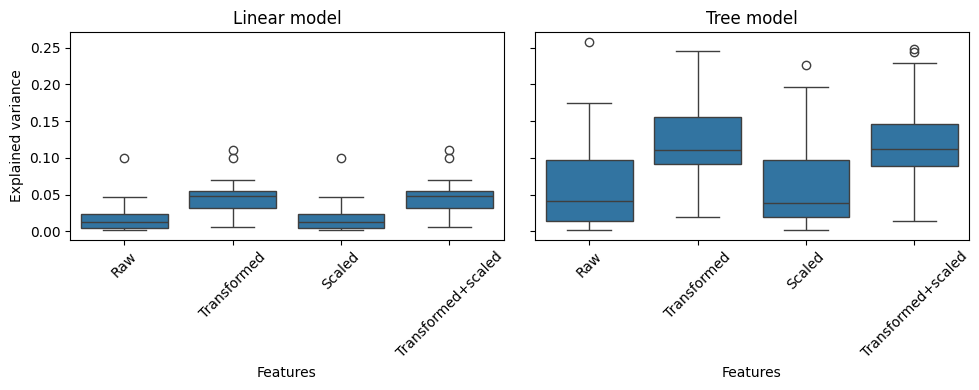

In [9]:
fig, axs=plt.subplots(1,2, figsize=(10,4), sharey=True)
axs=axs.flatten()

sns.boxplot(linear_results_df, x='Feature set', y='Explained variance', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('Features')
axs[0].tick_params(axis='x', labelrotation=45)

sns.boxplot(tree_results_df, x='Feature set', y='Explained variance', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('Features')
axs[1].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()